# COVID-19 Literature Clustering

### You can find the full version of the interactive plot here on GitHub: 
#### https://maksimekin.github.io/COVID19-Literature-Clustering/plots/t-sne_covid-19_interactive.html
Because of its size, I can only put the smaller version on this Notebook.



### Goal
Given a large amount of literature and rapidly spreading COVID-19, it is difficult for a scientist to keep up with the research community promptly. Can we cluster similar research articles together to make it easier for health professionals to find relevant research articles? Clustering can be used to create a tool to identify similar articles, given a target article. It can also reduce the number of articles one has to go through as one can focus on a cluster of articles rather than all. 

**Approach**:
<ol>
    <li>Unsupervised Learning task, because we don't have labels for the articles</li>
    <li>Clustering and Dimensionality Reduction task </li>
    <li>See how well labels from K-Means classify</li>
    <li>Use N-Grams with Hash Vectorizer</li>
    <li>Use plain text with Tf-idf</li>
    <li>Use K-Means for clustering</li>
    <li>Use t-SNE for dimensionality reduction</li>
    <li>Use PCA for dimensionality reduction</li>
    <li>There is no continuous flow of data, no need to adjust to changing data, and the data is small enough to fit in memmory: Batch Learning</li>
    <li>Altough, there is no continuous flow of data, our approach has to be scalable as there will be more literature later</li>
</ol>

### Dataset Description

>*In response to the COVID-19 pandemic, the White House and a coalition of leading research groups have prepared the COVID-19 Open Research Dataset (CORD-19). CORD-19 is a resource of over 29,000 scholarly articles, including over 13,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses. This freely available dataset is provided to the global research community to apply recent advances in natural language processing and other AI techniques to generate new insights in support of the ongoing fight against this infectious disease. There is a growing urgency for these approaches because of the rapid acceleration in new coronavirus literature, making it difficult for the medical research community to keep up.*
#### Cite: [COVID-19 Open Research Dataset Challenge (CORD-19) | Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) <br>

**Clustering section of the project (cite):** *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*, 2nd Edition, by Aurelien Geron (O'Reilly). Copyright 2019 Kiwisoft S.A.S, 978-1-492-03264-9. Machine Learning Practice. Implimenting this section following the Chapter-9 project on O'REILLY's Hands-On Machine Learning. <br>

# Load the Data
Load the data following the notebook by Ivan Ega Pratama, from Kaggle.
#### Cite: [Dataset Parsing Code | Kaggle, COVID EDA: Initial Exploration Tool](https://www.kaggle.com/ivanegapratama/covid-eda-initial-exploration-tool)

### Loading Metadata

In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Let's load the metadata of the dateset. 'title' and 'journal' attributes may be useful later when we cluster the articles to see what kinds of articles cluster together.

In [11]:
root_path = '/data/szr207/dataset/covidseer'
metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

sha  source_x  \
0                                       NaN  Elsevier   
1                                       NaN  Elsevier   
2                                       NaN  Elsevier   
3  aecbc613ebdab36753235197ffb4f35734b5ca63  Elsevier   
4                                       NaN  Elsevier   

                                               title  \
0  Intrauterine virus infections and congenital h...   
1                  Coronaviruses in Balkan nephritis   
2  Cigarette smoking and coronary heart disease: ...   
3  Clinical and immunologic studies in identical ...   
4  Epidemiology of community-acquired respiratory...   

                            doi pmcid pubmed_id    license  \
0  10.1016/0002-8703(72)90077-4   NaN   4361535  els-covid   
1  10.1016/0002-8703(80)90355-5   NaN   6243850  els-covid   
2  10.1016/0002-8703(80)90356-7   NaN   7355701  els-covid   
3  10.1016/0002-9343(73)90176-9   NaN   4579077  els-covid   
4  10.1016/0002-9343(85)90361-4   NaN   4014285  els-covid   

                                            abstract publish_time  \
0  Abstract The etiologic basis for the vast majo...   1972-12-31   
1                                                NaN   1980-03-31   
2                                                NaN   1980-03-31   
3  Abstract Middle-aged female identical twins, o...   1973-08-31   
4  Abstract Upper respiratory tract infections ar...   1985-06-28   

                                             authors  \
0                                  Overall, James C.   
1  Georgescu, Leonida; Diosi, Peter; Buţiu, Ioan;...   
2                                   Friedman, Gary D   
3  Brunner, Carolyn M.; Horwitz, David A.; Shann,...   
4                              Garibaldi, Richard A.   

                            journal Microsoft Academic Paper ID  \
0            American Heart Journal                         NaN   
1            American Heart Journal                         NaN   
2            American Heart Journal                         NaN   
3  The American Journal of Medicine                         NaN   
4  The American Journal of Medicine                         NaN   

  WHO #Covidence  has_full_text  full_text_file  
0            NaN          False  custom_license  
1            NaN          False  custom_license  
2            NaN          False  custom_license  
3            NaN           True  custom_license  
4            NaN          False  custom_license

In [12]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44220 entries, 0 to 44219
Data columns (total 15 columns):
sha                            28462 non-null object
source_x                       44220 non-null object
title                          43996 non-null object
doi                            40750 non-null object
pmcid                          23319 non-null object
pubmed_id                      22943 non-null object
license                        44220 non-null object
abstract                       35806 non-null object
publish_time                   34197 non-null object
authors                        41074 non-null object
journal                        33173 non-null object
Microsoft Academic Paper ID    964 non-null object
WHO #Covidence                 1767 non-null object
has_full_text                  44220 non-null bool
full_text_file                 32829 non-null object
dtypes: bool(1), object(14)
memory usage: 4.8+ MB


### Fetch All of JSON File Path

Get path to all JSON files:

In [13]:
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)
len(all_json)

29315

### Helper Functions

 File Reader Class

In [14]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

f056da9c64fbf00a4645ae326e8a4339d015d155: Next-generation sequencing is increasingly being used to study samples composed of mixtures of organisms, such as in clinical applications where the presence of a pathogen at very low abundance may be... There are many different methods that characterize the mixture of organisms present within a metagenomic dataset. Such datasets are generated when a complex environmental sample is processed by a "nex...


Helper function adds break after every words when character length reach to certain amount. This is for the interactive plot so that hover tool fits the screen.

In [15]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

### Load the Data into DataFrame

Using the helper functions, let's read in the articles into a DataFrame that can be used easily:

In [16]:
dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in tqdm(enumerate(all_json)):
   
    content = FileReader(entry)
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['paper_id'].append(content.paper_id)
    dict_['abstract'].append(content.abstract)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 300 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # more than 2 authors, may be problem when plotting, so take first 2 append with ...
            dict_['authors'].append(". ".join(authors[:2]) + "...")
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()


paper_id  \
0  f056da9c64fbf00a4645ae326e8a4339d015d155   
1  daf32e013d325a6feb80e83d15aabc64a48fae33   
2  f33c6d94b0efaa198f8f3f20e644625fa3fe10d2   
3  4da8a87e614373d56070ed272487451266dce919   
4  eccef80cfbe078235df22398f195d5db462d8000   

                                            abstract  \
0  Next-generation sequencing is increasingly bei...   
1  An emerging disease is one infectious epidemic...   
2  Germline variation at immunoglobulin gene (IG)...   
3  Deep sequencing of clinical samples is now an ...   
4  Background: Developing methods to reconstruct ...   

                                           body_text  \
0  There are many different methods that characte...   
1  The term metapopulation was coined by Levins [...   
2  Antibodies are essential components of the imm...   
3  Metagenomics can be defined as the analysis of...   
4  : Schematic of transmission links overlaid on ...   

                                    authors  \
0         Samuel Minot. Stephen D Turner...   
1                     Lin WANG. Xiang Li...   
2  Corey T Watson. Karyn Meltz Steinberg...   
3     Sofia Morfopoulou. Vincent Plagnol...   
4     Stephen P Velsko. Jonathan E Allen...   

                                               title journal  \
0   SIANN: Strain Identification by Alignment to<...     NaN   
1   Spatial epidemiology of networked<br>metapopu...     NaN   
2   Sequencing of the human IG light chain loci f...     NaN   
3   Bayesian mixture analysis for metagenomic<br>...     NaN   
4   Mapping a viral phylogeny onto outbreak trees...     NaN   

                                    abstract_summary  
0   Next-generation sequencing is increasingly<br...  
1   An emerging disease is one infectious epidemi...  
2   Germline variation at immunoglobulin gene<br>...  
3   Deep sequencing of clinical samples is now an...  
4   Background: Developing methods to<br>reconstr...

In [17]:
import gc
del(dict_)
gc.collect()

27

# Adding the Word Count Columns

Adding word count columns for both abstract and body_text can be useful parameters later:

In [18]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))
df_covid.head()

paper_id  \
0  f056da9c64fbf00a4645ae326e8a4339d015d155   
1  daf32e013d325a6feb80e83d15aabc64a48fae33   
2  f33c6d94b0efaa198f8f3f20e644625fa3fe10d2   
3  4da8a87e614373d56070ed272487451266dce919   
4  eccef80cfbe078235df22398f195d5db462d8000   

                                            abstract  \
0  Next-generation sequencing is increasingly bei...   
1  An emerging disease is one infectious epidemic...   
2  Germline variation at immunoglobulin gene (IG)...   
3  Deep sequencing of clinical samples is now an ...   
4  Background: Developing methods to reconstruct ...   

                                           body_text  \
0  There are many different methods that characte...   
1  The term metapopulation was coined by Levins [...   
2  Antibodies are essential components of the imm...   
3  Metagenomics can be defined as the analysis of...   
4  : Schematic of transmission links overlaid on ...   

                                    authors  \
0         Samuel Minot. Stephen D Turner...   
1                     Lin WANG. Xiang Li...   
2  Corey T Watson. Karyn Meltz Steinberg...   
3     Sofia Morfopoulou. Vincent Plagnol...   
4     Stephen P Velsko. Jonathan E Allen...   

                                               title journal  \
0   SIANN: Strain Identification by Alignment to<...     NaN   
1   Spatial epidemiology of networked<br>metapopu...     NaN   
2   Sequencing of the human IG light chain loci f...     NaN   
3   Bayesian mixture analysis for metagenomic<br>...     NaN   
4   Mapping a viral phylogeny onto outbreak trees...     NaN   

                                    abstract_summary  abstract_word_count  \
0   Next-generation sequencing is increasingly<br...                  183   
1   An emerging disease is one infectious epidemi...                  136   
2   Germline variation at immunoglobulin gene<br>...                  200   
3   Deep sequencing of clinical samples is now an...                  298   
4   Background: Developing methods to<br>reconstr...                  429   

   body_word_count  
0             3692  
1             5000  
2             5478  
3             6486  
4             6225

In [19]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27678 entries, 0 to 27677
Data columns (total 9 columns):
paper_id               27678 non-null object
abstract               27678 non-null object
body_text              27678 non-null object
authors                26929 non-null object
title                  27634 non-null object
journal                26784 non-null object
abstract_summary       27678 non-null object
abstract_word_count    27678 non-null int64
body_word_count        27678 non-null int64
dtypes: int64(2), object(7)
memory usage: 1.9+ MB


In [20]:
df_covid['abstract'].describe(include='all')

count     27678
unique    20191
top            
freq       7453
Name: abstract, dtype: object

# Handle Possible Duplicates

When we look at the unique values above, we can see that tehre are duplicates. It may have caused because of author submiting the article to multiple journals. Let's remove the duplicats from our dataset:

(Thank you Desmond Yeoh for recommending the below approach on Kaggle)

In [21]:
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True)

df_covid = df_covid.replace(r'^\s*$', np.NaN, regex=True)


df_covid["abstract"].fillna(df_covid["title"], inplace = True) 

In [39]:
df_covid["abstract"].values

array(['To understand the time-dependent risk of infection on a cruise ship, the Diamond Princess, I estimated the incidence of infection with novel coronavirus . The epidemic curve of a total of 199 confirmed cases was drawn, classifying individuals into passengers with and without close contact and crew members. A backcalculation method was employed to estimate the incidence of infection. The peak time of infection was seen for the time period from 2 to 4 February 2020, and the incidence has abruptly declined afterwards. The estimated number of new infections among passengers without close contact was very small from 5 February on which a movement restriction policy was imposed. Without the intervention from 5 February, it was predicted that the cumulative incidence with and without close contact would have been as large as 1373 (95% CI: 570, 2176) and 766 (95% CI: 587, 946) cases, respectively, while these were kept to be 102 and 47 cases, respectively. Based on an analysis of illne

In [23]:
df_covid = df_covid.dropna()

In [24]:
df_covid.shape

(26044, 9)

In [25]:
df_covid['abstract'].describe(include='all')

count           26044
unique          25940
top        Commentary
freq                6
Name: abstract, dtype: object

In [134]:
df_covid['body_text'].describe(include='all')

count                                                 27663
unique                                                27662
top       In a global world, knowledge of imported infec...
freq                                                      2
Name: body_text, dtype: object

It looks like we didn't have duplicates. Instead, it was articles without Abstracts.

# Take a Look at the Data:

In [15]:
df_covid.head()

paper_id  \
0  f056da9c64fbf00a4645ae326e8a4339d015d155   
1  daf32e013d325a6feb80e83d15aabc64a48fae33   
2  f33c6d94b0efaa198f8f3f20e644625fa3fe10d2   
3  4da8a87e614373d56070ed272487451266dce919   
4  eccef80cfbe078235df22398f195d5db462d8000   

                                            abstract  \
0  Next-generation sequencing is increasingly bei...   
1  An emerging disease is one infectious epidemic...   
2  Germline variation at immunoglobulin gene (IG)...   
3  Deep sequencing of clinical samples is now an ...   
4  Background: Developing methods to reconstruct ...   

                                           body_text  \
0  There are many different methods that characte...   
1  The term metapopulation was coined by Levins [...   
2  Antibodies are essential components of the imm...   
3  Metagenomics can be defined as the analysis of...   
4  : Schematic of transmission links overlaid on ...   

                                    authors  \
0         Samuel Minot. Stephen D Turner...   
1                     Lin WANG. Xiang Li...   
2  Corey T Watson. Karyn Meltz Steinberg...   
3     Sofia Morfopoulou. Vincent Plagnol...   
4     Stephen P Velsko. Jonathan E Allen...   

                                               title journal  \
0   SIANN: Strain Identification by Alignment to<...     NaN   
1   Spatial epidemiology of networked<br>metapopu...     NaN   
2   Sequencing of the human IG light chain loci f...     NaN   
3   Bayesian mixture analysis for metagenomic<br>...     NaN   
4   Mapping a viral phylogeny onto outbreak trees...     NaN   

                                    abstract_summary  abstract_word_count  \
0   Next-generation sequencing is increasingly<br...                  183   
1   An emerging disease is one infectious epidemi...                  136   
2   Germline variation at immunoglobulin gene<br>...                  200   
3   Deep sequencing of clinical samples is now an...                  298   
4   Background: Developing methods to<br>reconstr...                  429   

   body_word_count  
0             3692  
1             5000  
2             5478  
3             6486  
4             6225

In [16]:
df_covid.describe()

abstract_word_count  body_word_count
count         27678.000000     27678.000000
mean            165.438399      4885.414047
std             175.670244      7492.709215
min               0.000000         1.000000
25%               0.000000      2503.000000
50%             162.000000      3760.000000
75%             240.000000      5531.750000
max            4767.000000    260378.000000

# Data Pre-processing

Now that we have our dataset loaded, we need to clean-up the text to improve any clustering or classification efforts. First, let's drop Null vales:

In [9]:
df_covid.dropna(inplace=True)
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26055 entries, 885 to 27677
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             26055 non-null  object
 1   abstract             26055 non-null  object
 2   body_text            26055 non-null  object
 3   authors              26055 non-null  object
 4   title                26055 non-null  object
 5   journal              26055 non-null  object
 6   abstract_summary     26055 non-null  object
 7   abstract_word_count  26055 non-null  int64 
 8   body_word_count      26055 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 2.0+ MB


Limit number of articles to speed up computation:

In [19]:
# df_covid = df_covid.head(12500)

Now let's remove punctuation from each text:

In [10]:
import re

df_covid['body_text'] = df_covid['body_text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

Convert each text to lower case:

In [11]:
def lower_case(input_str):
    input_str = input_str.lower()
    return input_str

df_covid['body_text'] = df_covid['body_text'].apply(lambda x: lower_case(x))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: lower_case(x))

In [48]:
df_covid.head(4)

paper_id  \
0  f056da9c64fbf00a4645ae326e8a4339d015d155   
1  daf32e013d325a6feb80e83d15aabc64a48fae33   
2  f33c6d94b0efaa198f8f3f20e644625fa3fe10d2   
3  4da8a87e614373d56070ed272487451266dce919   

                                            abstract  \
0  Next-generation sequencing is increasingly bei...   
1  An emerging disease is one infectious epidemic...   
2  Germline variation at immunoglobulin gene (IG)...   
3  Deep sequencing of clinical samples is now an ...   

                                           body_text  \
0  There are many different methods that characte...   
1  The term metapopulation was coined by Levins [...   
2  Antibodies are essential components of the imm...   
3  Metagenomics can be defined as the analysis of...   

                                    authors  \
0         Samuel Minot. Stephen D Turner...   
1                     Lin WANG. Xiang Li...   
2  Corey T Watson. Karyn Meltz Steinberg...   
3     Sofia Morfopoulou. Vincent Plagnol...   

                                               title journal  \
0   SIANN: Strain Identification by Alignment to<...     NaN   
1   Spatial epidemiology of networked<br>metapopu...     NaN   
2   Sequencing of the human IG light chain loci f...     NaN   
3   Bayesian mixture analysis for metagenomic<br>...     NaN   

                                    abstract_summary  abstract_word_count  \
0   Next-generation sequencing is increasingly<br...                  183   
1   An emerging disease is one infectious epidemi...                  136   
2   Germline variation at immunoglobulin gene<br>...                  200   
3   Deep sequencing of clinical samples is now an...                  298   

   body_word_count  
0             3692  
1             5000  
2             5478  
3             6486

Now that we have the text cleaned up, we can create our features vector which can be fed into a clustering or dimensionality reduction algorithm. For our first try, we will focus on the text on the body of the articles. Let's grab that:

In [26]:
text = df_covid.drop(["paper_id", "abstract", "abstract_word_count", "body_word_count", "authors", "title", "journal", "abstract_summary"], axis=1)
paper_id = df_covid.drop([ "body_text","abstract", "abstract_word_count", "body_word_count", "authors", "title", "journal", "abstract_summary"], axis=1)

In [27]:
abstracts = df_covid.drop(["paper_id", "body_text", "abstract_word_count", "body_word_count", "authors", "title", "journal", "abstract_summary"], axis=1)

In [28]:
abstracts.dropna()

abstract
885    To understand the time-dependent risk of infec...
886    A.A.Q); m.mckay@ust.hk (M.R.M.) † These author...
887    The exported cases of 2019 novel coronavirus i...
888     A pneumonia outbreak associated with a new<br...
889    The outbreak of pneumonia originating in Wuhan...
...                                                  ...
27673  The rapidly growing understanding of human gen...
27674   MERS-CoV and H5N1 influenza virus antagonize<...
27675   Disease features of equine coronavirus and<br...
27676  Background. Chronic lung allograft dysfunction...
27677  RNA viruses encode an RNA-dependent RNA polyme...

[26044 rows x 1 columns]

In [29]:
abstracts.shape

(26044, 1)

In [148]:
paper_id.shape

(19214, 1)

Let's transform 1D DataFrame into 1D list where each index is an article (instance), so that we can work with words from each instance:

In [15]:
text_arr = text.stack().tolist()
len(text_arr)

26055

# 2-Grams

Let's create 2D list, where each row is instance and each column is a word. Meaning, we will separate each instance into words:  

In [26]:
words = []
for ii in range(0,len(text)):
    words.append(str(text.iloc[ii]['body_text']).split(" "))

In [27]:
print(words[0][:10])

['live', 'attenuated', 'viruses', 'have', 'been', 'developed', 'and', 'used', 'to', 'help']


What we want now is n-grams from the words where n=2 (2-gram). We will still have 2D array where each row is an instance; however, each index in that row going to be a 2-gram:

In [28]:
n_gram_all = []

for word in words:
    # get n-grams for the instance
    n_gram = []
    for i in range(len(word)-2+1):
        n_gram.append("".join(word[i:i+2]))
    n_gram_all.append(n_gram)

In [29]:
n_gram_all[0][:10]

['liveattenuated',
 'attenuatedviruses',
 'viruseshave',
 'havebeen',
 'beendeveloped',
 'developedand',
 'andused',
 'usedto',
 'tohelp',
 'helpprotect']

# Vectorize with HashingVectorizer

Now we will use HashVectorizer to create the features vector X. For now, let's limit the feature size to 2**12(4096) to speed up the computation. We might need to increase this later to reduce the collusions and improve the accuracy:

In [30]:
from sklearn.feature_extraction.text import HashingVectorizer

# hash vectorizer instance
hvec = HashingVectorizer(lowercase=False, analyzer=lambda l:l, n_features=2**12)

# features matrix X
X = hvec.fit_transform(n_gram_all)

In [31]:
X.shape

(12500, 4096)

#### Separete Training and Test Set

In [32]:
from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test = train_test_split(X.toarray(), test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 10000
X_test size: 2500 



# Dimensionality Reduction with t-SNE
Using t-SNE we can reduce our high dimensional features vector into 2 dimensional plane. In the process, t-SNE will keep similar instances together while trying to push different instances far from each other. Resulting 2-D plane can be useful to see which articles cluster near each other:

In [33]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=5)
X_embedded = tsne.fit_transform(X_train)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 10000 samples in 17.603s...
[t-SNE] Computed neighbors for 10000 samples in 1195.511s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.131599
[t-SNE] KL divergence after 250 iterations with early exaggeration: 137.875183
[t-SNE] KL divergence after 1000 iterations: 3.776476


Let's plot the result:

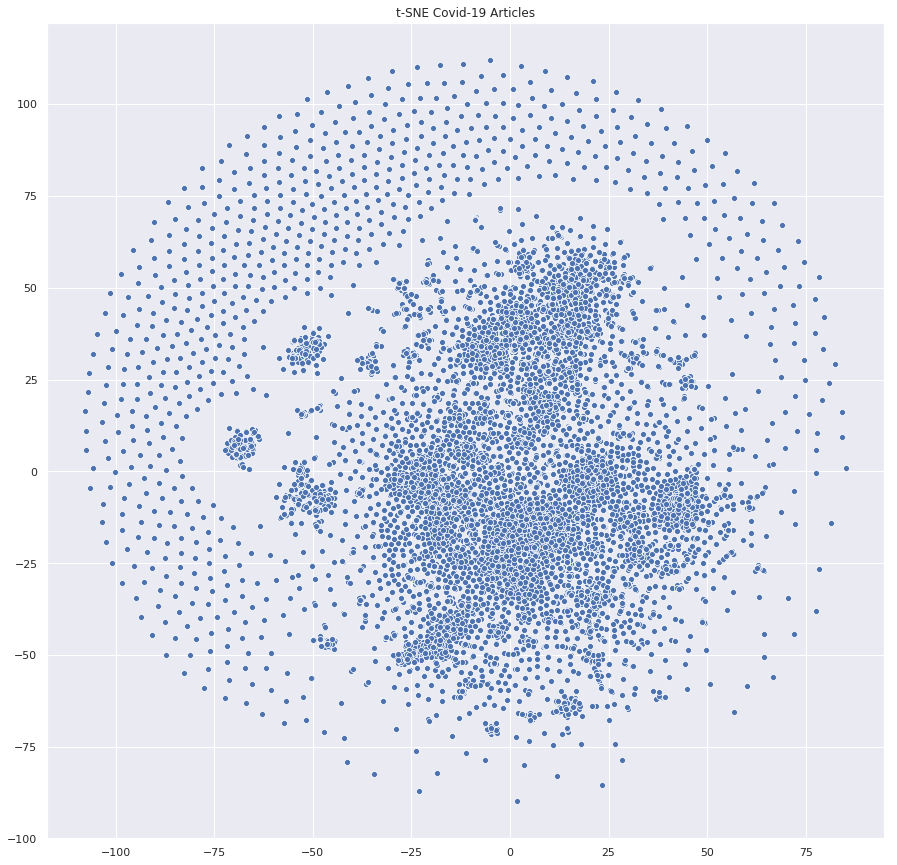

In [34]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)

plt.title("t-SNE Covid-19 Articles")
# plt.savefig("plots/t-sne_covid19.png")
plt.show()

We can clearly see few clusters forming. This may be a good sign that we are able to cluster similar articles together using 2-grams and HashVectorizer with 2**10 features. However, without labels it is difficult to see the clusters. For now, it looks like a blob of data... Let's try if we can use K-Means to generate our labels. We can later use this information to produce a scatterplot with labels to verify the clusters.

# Unsupervised Learning: Clustering with K-Means

Using K-means we will get the labels we need. For now, we will create 10 clusters. I am choosing this arbitrarily. We can change this later.

In [35]:
from sklearn.cluster import KMeans

k = 10
kmeans = KMeans(n_clusters=k, n_jobs=4, verbose=10)
y_pred = kmeans.fit_predict(X_train)

Labels for the training set:

In [36]:
y_train = y_pred

Labels for the test set:

In [37]:
y_test = kmeans.predict(X_test)

Now that we have the labels, let's plot the t-SNE. scatterplot again and see if we have any obvious clusters:

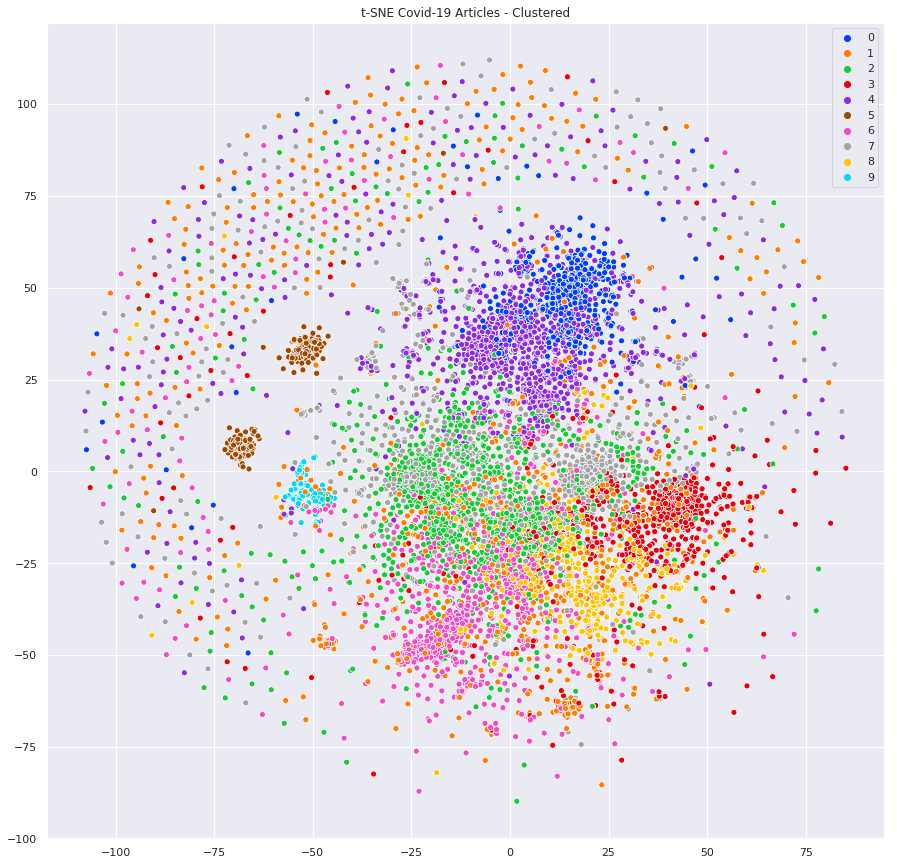

In [38]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y_pred)))

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered")
# plt.savefig("plots/t-sne_covid19_label.png")
plt.show()

That looks pretty promising. It can be seen that articles from the same cluster are near each other, forming groups. There are still overlaps. So we will have to see if we can improve this by changing the cluster size, using another clustering algorithm, or different feature size. We can also consider not using 2-grams, or HashVectorizer. We can try 3-grams, 4-grams, or plain text as our instances and vectorize them using either HashVectorizer, Tf-idfVectorizer, or Burrows Wheeler Transform Distance. <br>

Before we try another method for clustering, we want to see how well it will classify using the labels we just created using K-Means.

# Classify

### Helper Function:

In [39]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='micro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='micro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='micro')) * 100), "%")

### Random Forest

In [40]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# random forest classifier instance
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=4)

# cross validation on the training set 
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the mean of the cross validation scores
print("Accuracy: ", '{:,.3f}'.format(float(forest_scores.mean()) * 100), "%")

Accuracy:  71.740 %


In [41]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score

# cross validate predict on the training set
forest_train_pred = cross_val_predict(forest_clf, X_train, y_train, cv=3, n_jobs=4)

# print precision and recall scores
print("Precision: ", '{:,.3f}'.format(float(precision_score(y_train, forest_train_pred, average='macro')) * 100), "%")
print("   Recall: ", '{:,.3f}'.format(float(recall_score(y_train, forest_train_pred, average='macro')) * 100), "%")

Precision:  79.915 %
   Recall:  66.141 %


In [42]:
# first train the model
forest_clf.fit(X_train, y_train)

# make predictions on the test set
forest_pred = forest_clf.predict(X_test)

In [43]:
# print out the classification report
classification_report("Random Forest Classifier Report (Test Set)", y_test, forest_pred)

Random Forest Classifier Report (Test Set) :

Accuracy Score:  74.000 %
     Precision:  74.000 %
        Recall:  74.000 %
      F1 score:  74.000 %


It looks like it doesn't overfit, which is good news. But results can be better than ~70-80%. So we might want to come back to this later again to see if we can improve it.  

# Vectorize Using Tf-idf with Plain Text
Let's see if we will be able to get better clusters using plain text as instances rather than 2-grams and vectorize it using Tf-idf. Last time we separated the dataset into test and training sets because we wanted to do classification with the labels we got through clustering. This time we will just use the all dataset because the goal is to cluster all literature.

### Vectorize

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2**12)
X = vectorizer.fit_transform(df_covid['abstract'].values)

In [54]:
X.shape

(26044, 4096)

# MiniBatchKMeans with Plain text and Tf-idf

Again, let's try to get our labels. We will choose 10 clusters again. This time, we will use MiniBatchKMeans as it is faster with more data:

In [55]:
from sklearn.cluster import MiniBatchKMeans

k = 20
kmeans = MiniBatchKMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

Get the labels:

In [56]:
y = y_pred

# Dimensionality Reduction with t-SNE (Plain text and Tf-idf)

Let's reduce the dimensionality using t-SNE again:

In [57]:
# from sklearn.manifold import TSNE

# tsne = TSNE(verbose=1)
# X_embedded = tsne.fit_transform(X.toarray())

from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_jobs=40, verbose=1)
X_embedded = tsne.fit_transform(X.toarray())

### Plot t-SNE

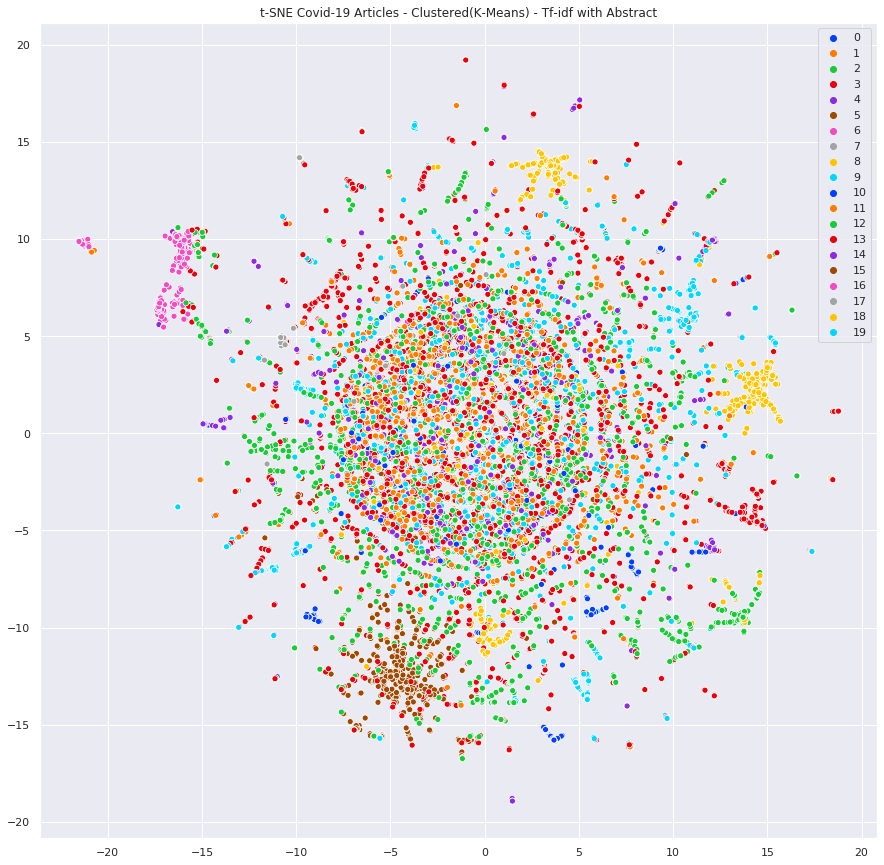

In [58]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y)))

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered(K-Means) - Tf-idf with Abstract")
# plt.savefig("plots/t-sne_covid19_label_TFID.png")
plt.show()

This time we are able to see the clusters more clearly. There are clusters that further apart from each other. I can also start to see that there is possibly more than 10 clusters we need to identify using k-means.

# BERT Embeddings with Plain Text

In [59]:
import functools
import operator

list_abs = abstracts.values.tolist()
abstract_l = functools.reduce(operator.iconcat, list_abs, [])

In [60]:
from bert_serving.client import BertClient
bc = BertClient()  # ip address of the GPU machine
abs_emb = bc.encode(abstract_l)

/data/szr207/conda/envs/tf-gpu/lib/python3.7/site-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=25" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)


In [61]:
X = abs_emb
del(abs_emb)
X.shape

(26044, 768)

In [62]:
from sklearn.cluster import MiniBatchKMeans

k = 20
kmeans = MiniBatchKMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)
y = y_pred

from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_jobs=40, verbose=1)
X_embedded = tsne.fit_transform(X)

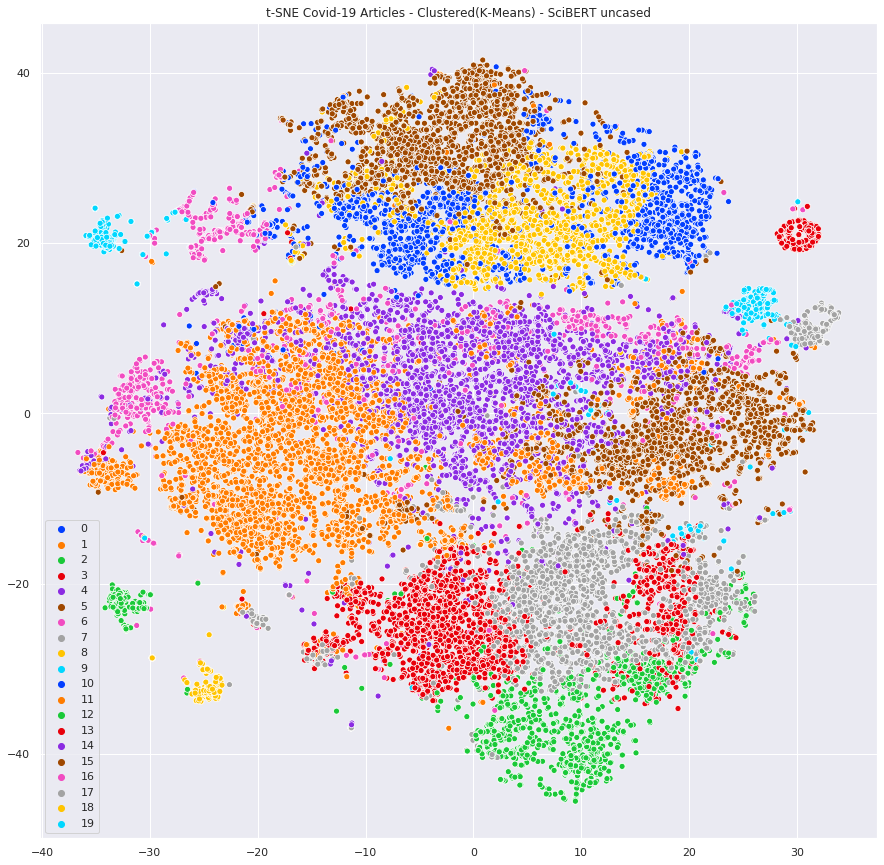

In [64]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y)))

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered(K-Means) - SciBERT uncased")
# plt.savefig("plots/t-sne_covid19_label_TFID.png")
plt.show()

# Dimensionality Reduction with PCA (Plain text and Tf-idf)

t-SNE doesn't scale well. This is why run-time of this Notebook is about 40 minutes to 1 hour with an average computer. Let's try to see if we dan achive good results with PCA as it scales very well with larger datasets and dimensions:

In [65]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)

### Plot PCA

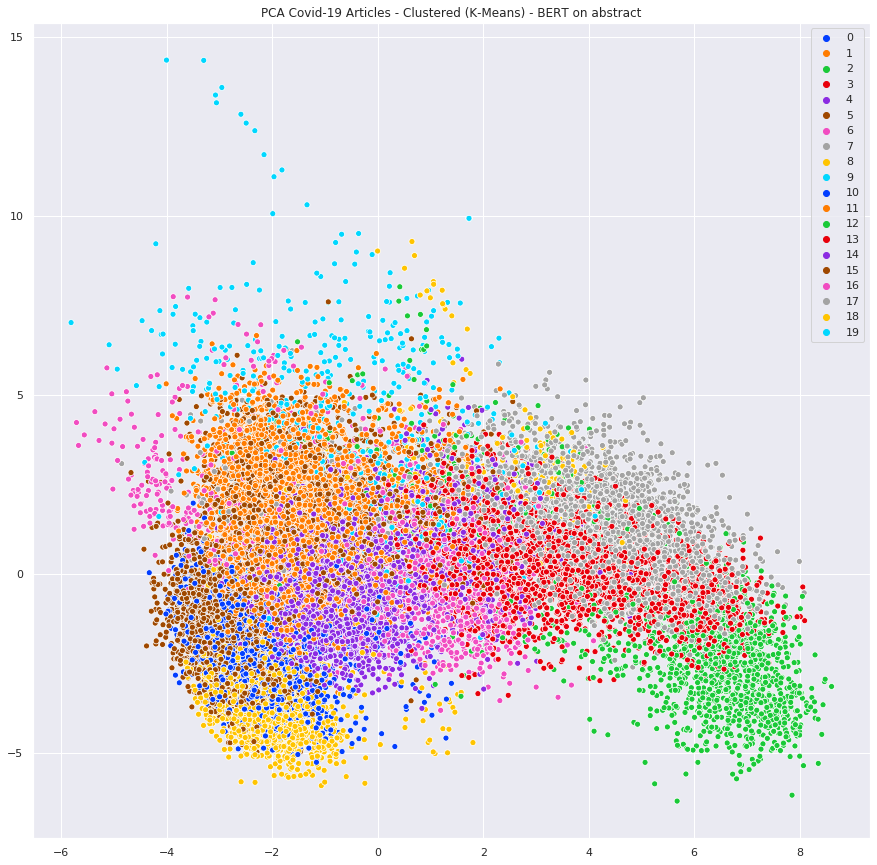

In [66]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y)))

# plot
sns.scatterplot(pca_result[:,0], pca_result[:,1], hue=y, legend='full', palette=palette)
plt.title("PCA Covid-19 Articles - Clustered (K-Means) - BERT on abstract")
# plt.savefig("plots/pca_covid19_label_TFID.png")
plt.show()

Sometimes it may be easier to see the results in a 3 dimensional plot. So let's try to do that:

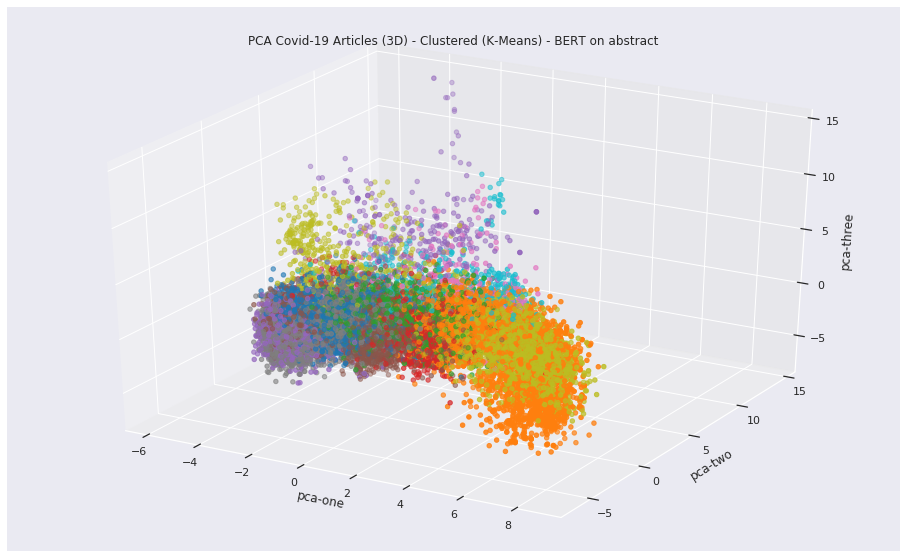

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_result[:,0], 
    ys=pca_result[:,1], 
    zs=pca_result[:,2], 
    c=y, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.title("PCA Covid-19 Articles (3D) - Clustered (K-Means) - BERT on abstract")
# plt.savefig("plots/pca_covid19_label_TFID_3d.png")
plt.show()

# More Clusters?
On our previous plot we could see that there is more clusters than only 10. Let's try to label them:

In [53]:
from sklearn.cluster import MiniBatchKMeans

k = 20
kmeans = MiniBatchKMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)
y = y_pred

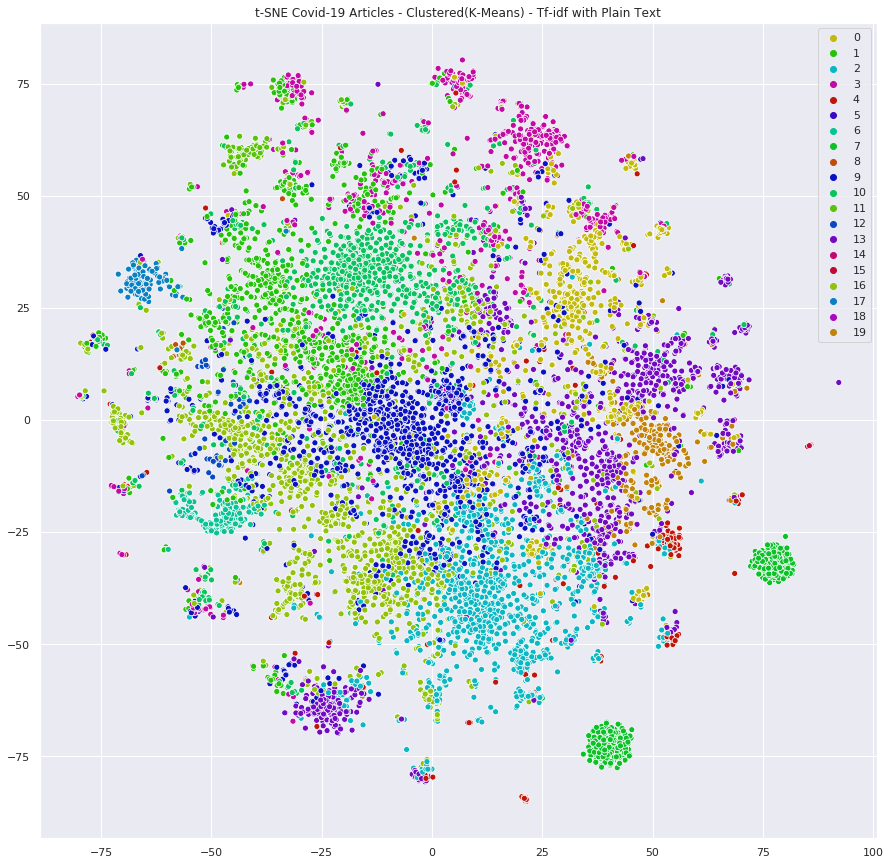

In [54]:
from matplotlib import pyplot as plt
import seaborn as sns
import random 

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# let's shuffle the list so distinct colors stay next to each other
palette = sns.hls_palette(20, l=.4, s=.9)
random.shuffle(palette)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered(K-Means) - Tf-idf with Plain Text")
# plt.savefig("plots/t-sne_covid19_20label_TFID.png")
plt.show()

It would be helpful if we have a demo tool that can be used to see what articles are identified as similar using our Clustering and Dimensionality Reduction, right? Let's put together a interactive scatter plot of t-SNE to do that.

# Interactive t-SNE

In [51]:
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap
from bokeh.io import output_file, show
from bokeh.transform import transform
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import column
from bokeh.models import RadioButtonGroup
from bokeh.models import TextInput
from bokeh.layouts import gridplot
from bokeh.models import Div
from bokeh.models import Paragraph
from bokeh.layouts import column, widgetbox

output_notebook()
y_labels = y_pred

# data sources
source = ColumnDataSource(data=dict(
    x= X_embedded[:,0], 
    y= X_embedded[:,1],
    x_backup = X_embedded[:,0],
    y_backup = X_embedded[:,1],
    desc= y_labels, 
    titles= df_covid['title'],
    authors = df_covid['authors'],
    journal = df_covid['journal'],
    abstract = df_covid['abstract_summary'],
    labels = ["C-" + str(x) for x in y_labels]
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Author(s)", "@authors"),
    ("Journal", "@journal"),
    ("Abstract", "@abstract{safe}"),
],
                 point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
p = figure(plot_width=800, plot_height=800, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset'], 
           title="t-SNE Covid-19 Articles, Clustered(K-Means), Tf-idf with Plain Text", 
           toolbar_location="right")

# plot
p.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          legend = 'labels')

# add callback to control 
callback = CustomJS(args=dict(p=p, source=source), code="""
            
            var radio_value = cb_obj.active;
            var data = source.data; 
            
            x = data['x'];
            y = data['y'];
            
            x_backup = data['x_backup'];
            y_backup = data['y_backup'];
            
            labels = data['desc'];
            
            if (radio_value == '20') {
                for (i = 0; i < x.length; i++) {
                    x[i] = x_backup[i];
                    y[i] = y_backup[i];
                }
            }
            else {
                for (i = 0; i < x.length; i++) {
                    if(labels[i] == radio_value) {
                        x[i] = x_backup[i];
                        y[i] = y_backup[i];
                    } else {
                        x[i] = undefined;
                        y[i] = undefined;
                    }
                }
            }


        source.change.emit();
        """)

# callback for searchbar
keyword_callback = CustomJS(args=dict(p=p, source=source), code="""
            
            var text_value = cb_obj.value;
            var data = source.data; 
            
            x = data['x'];
            y = data['y'];
            
            x_backup = data['x_backup'];
            y_backup = data['y_backup'];
            
            abstract = data['abstract'];
            titles = data['titles'];
            authors = data['authors'];
            journal = data['journal'];

            for (i = 0; i < x.length; i++) {
                if(abstract[i].includes(text_value) || 
                   titles[i].includes(text_value) || 
                   authors[i].includes(text_value) || 
                   journal[i].includes(text_value)) {
                    x[i] = x_backup[i];
                    y[i] = y_backup[i];
                } else {
                    x[i] = undefined;
                    y[i] = undefined;
                }
            }
            


        source.change.emit();
        """)

# option
option = RadioButtonGroup(labels=["C-0", "C-1", "C-2",
                                  "C-3", "C-4", "C-5",
                                  "C-6", "C-7", "C-8",
                                  "C-9", "C-10", "C-11",
                                  "C-12", "C-13", "C-14",
                                  "C-15", "C-16", "C-17",
                                  "C-18", "C-19", "All"], 
                          active=20, callback=callback)

# search box
keyword = TextInput(title="Search:", callback=keyword_callback)

#header
header = Div(text="""<h1>COVID-19 Literature Cluster</h1>""")

# show
show(column(header, widgetbox(option, keyword),p))

Loading BokehJS ...

AttributeError: unexpected attribute 'callback' to RadioButtonGroup, similar attributes are js_event_callbacks

#### Please see the tools on right top.
#### If the text doesn't fit in the screen on the above plot when hover, please try the 'Box Zoom' tool to zoom to the area where the target plot is. This will help the hover message to fit the screen. 
#### Use the 'Reset' button to revert the zoom.